In [1]:
# Notebook header for loading packages

import os
import matplotlib
matplotlib.use("TkAgg")

from jarvis.tools.slme import SolarCell;

vasp_bulk_exe /users/knc6/VASP/vasp54/src/vasp.5.4.1Dobby/bin/vasp_std
vasp_surf_exe /users/knc6/VASP/vasp54/src/vasp.5.4.1Dobbynoz/bin/vasp_std
vasp_nw_exe /users/knc6/VASP/vasp54/src/vasp.5.4.1Dobbynoxy/bin/vasp_ncl
vasp_soc_exe /users/knc6/VASP/vasp54/src/vasp.5.4.1Dobby/bin/vasp_ncl
vasp_vdw_dat /users/knc6/bin/vdw_kernel.bindat
lammps_exec ~/Software/LAMMPS/lammps-master/src/lmp_serial
VASP_PSP_DIR /users/knc6/VASP/VASP-POTENTIAL
MAPI_KEY ''
data_json /users/knc6/bin/all_mp.json
ncores 24
nnodes 8
mem 1500
walltime 148:12:00
input_nobox /users/knc6/inelast_nobox.mod
input_box /users/knc6/inelast.mod
mp_cmd mpirun


# Influence of the onset of the absorption spectrum on the SLME

In this notebook, we'll take a quick look a the influence of the onset of the absorption spectrum on the final result for the SLME, as well as the thickness dependence. Of particular interest are the comparison with the shockley-queisser limit, as the small onset can have a significant influence on the SLME as the thickness increases, and as such remove the possibility of crossing the shockley-queisser limit, as we found to be possible in our CuAu-like paper. The basic idea is that because the recombination current is calculated from the combination of the absorptivity and the temperature-dependent blackbody spectrum:

$$
J_0^r = e \pi \int_0^\infty a(E) \Phi_{bb} (E, T) dE
$$

Let's stick to the radiative limit for now, i.e. $J_0=J_0^r$. In case there is an earlier onset of the absorptivity $a(E)$, this will increase the recombination current, which is clear from the integral above. There are several ways to obtain an onset of the absorptivity below the band gap:

* Smearing (or smoothening, whatever you want to call it) of the imaginary part of the dielectric function because of the complex integration used in the Kramer-Kronig transformation in VASP. When performing the Kramers-Kronig transformation, the imaginary part of the dielectric function is overwritten by the smeared version. After this step, there is the following piece of code in the `linear_optics.F` file:<br><br>
```
2244 ! this line overwrites the imaginary part by the original data
2245 ! passed to the subroutine
2246 ! the option is usually selected if the complex shift is small,
2247 ! since in this case the KK transformation above yields inaccurate results
2248 ! for the imaginary part
2249 ! however, this, option can not be used if the input data is already complex
2250 ! values
2251       IF (ABS(CSHIFT) < DELTAE .AND. .NOT. LCOPY) THEN
2252          LWARN=.TRUE.
2253       ENDIF
2254       IF (ABS(CSHIFT) < DELTAE .AND. LCOPY) THEN
2255          EPS_REAL=CMPLX(REAL(EPS_REAL,q),REAL(EPSDD,q))
2256       ENDIF
2257 
2258       EPSDD=EPS_REAL
```
<br>
Simply put, this piece of code once again overwrites the imaginary part of the dielectric function with the original one calculated from the matrix elements 
(line 2255), on two conditions: The CSHIFT value is smaller than the spacing of the energy mesh and there are no significant imaginary parts in the original imaginary part of the dielectric function.<br><br>
* Using smearing in order to aid the k-point convergence. The influence of this smearing will of course depend on the amount of smearing used.
* Interpolation of the energy grid. If the band gap is in between two energy grid points (which is usually the case), and the distance between the grid point is significantly large, the interpolation of the absorptivity can lead to a small but significant onset below the bandgap.

Let's take a closer look at the various onset-related errors for the SLME calculation.

## CSHIFT

First let's compare the difference between the onset for two CSHIFT choices: 0.1 (highc) and 0.01 (lowc). We'll immediately load the dielectric tensor into a `SolarCell` object:

In [2]:
cuinse2_lowc_n2000 = SolarCell.from_file(os.path.join(os.getcwd(), "data", "lowc_nedos2000.xml"))
cuinse2_highc_n2000 = SolarCell.from_file(os.path.join(os.getcwd(), "data", "highc_nedos2000.xml"))

Next let's plot the onset of the imaginary part of the dielectric function and compare the two:

CSHIFT = 0.01


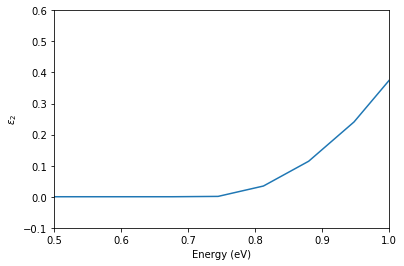

CSHIFT = 0.1


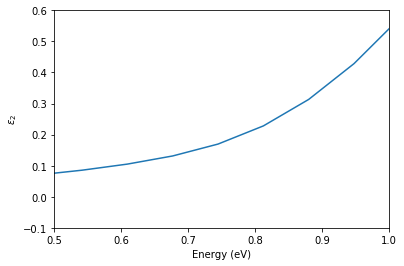

In [3]:
%matplotlib inline
print("CSHIFT = 0.01")
cuinse2_lowc_n2000.dieltensor.plot(part="imag", variable_range=(0.5, 1), diel_range=(-0.1, 0.6))
print("CSHIFT = 0.1")
cuinse2_highc_n2000.dieltensor.plot(part="imag", variable_range=(0.5, 1), diel_range=(-0.1, 0.6))

It's clear that the imaginary part of the highc version has an earlier onset. Let's make sure the lowc version starts at the band gap:

In [4]:
print("CSHIFT = 0.01, bandgaps: " + str(cuinse2_lowc_n2000.bandgaps))
print("CSHIFT = 0.1, bandgaps: " + str(cuinse2_highc_n2000.bandgaps))

CSHIFT = 0.01, bandgaps: (0.7295000000000003, 0.7295000000000003)
CSHIFT = 0.1, bandgaps: (0.7295000000000003, 0.7295000000000003)


Next, let's see the influence on the absorption coefficient:

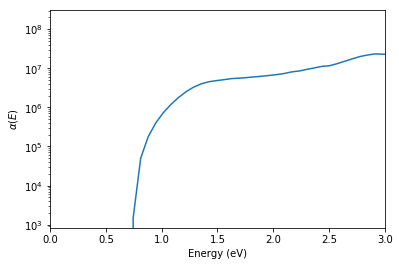

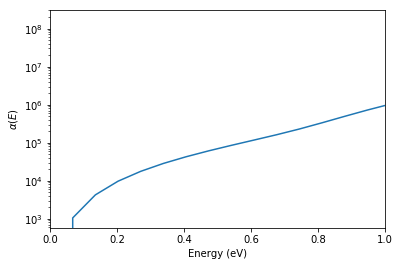

In [5]:
cuinse2_lowc_n2000.dieltensor.plot(part="abs_coeff", variable_range=(0, 3))
cuinse2_highc_n2000.dieltensor.plot(part="abs_coeff", variable_range=(0, 1))

We can see that the effect on the absorption coefficient is pretty dramatic! Finally, we'll check the influence on the SLME by plotting the slme versus the thickness, for which we've designed a barebone method:

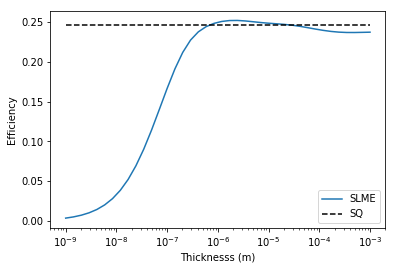

In [ ]:
cuinse2_lowc_n2000.plot_slme_vs_thickness(temperature=298.15)

In [ ]:
cuinse2_highc_n2000.plot_slme_vs_thickness(temperature=298.15)

Obviously, the earlier onset of the absorption coefficient severely reduces the SLME for all thicknesses. We can also see, however, that the SLME for the lowc case does not converge neatly to the SQ limit. This is because the band gap is not in the energy grid of the VASP optics calculation, which results in a small earlier onset due to interpolation, as described above. Below we load the results of a calculation of the optical properties with `NEDOS = 6000`, also with `CSHIFT=0.01`:

In [ ]:
cuinse2_lowc_n6000 = SolarCell.from_file(os.path.join(os.getcwd(), "data", "lowc_nedos6000.xml"))

Nevermind the float overflow, that's in the current-current version of the dielectric function, which I suppose calculated the dielectric function using another method. But so far I've only found strange results for the current-current dielectric function. Let's look at the thickness dependence of the SLME:

In [ ]:
cuinse2_lowc_n6000.plot_slme_vs_thickness(temperature=298.15)

Now we can see that the SLME does nicely converge to the SQ limit as the thickness $\rightarrow\infty$. However, as I'm sure you've noticed, the SLME crosses the SQ limit around $10^{-6}$ m! This effect becomes more pronounced when you increase the temperature to 338.15 K (65°C, which is not an unrealistic temperature for solar cells in operation):

In [ ]:
cuinse2_lowc_n6000.plot_slme_vs_thickness(temperature=338.15)

Also note that the efficiency has gone down, which is to be expected, because a higher operating temperature leads to an increased recombination current.

## Cutting off the onset

Let's see what happens if we try to fix this issue by cutting off the onset, i.e. reducing the absorptivity to zero below the band gap. (Another option would be to cut the imaginary part of the dielectric function, this would require recalculating the real part using the Kramers-Kronig transformation.) I've added an option to the `SolarCell.slme` and `SolarCell.plot_slme_vs_thickness` methods. Let's give them a spin:

In [ ]:
cuinse2_lowc_n6000.plot_slme_vs_thickness(temperature=298.15, cut_abs_below_bandgap=True)
cuinse2_highc_n2000.plot_slme_vs_thickness(temperature=298.15, cut_abs_below_bandgap=True)

As expected, removing the absorptivity below the band gap has little to no influence on the SLME for the `CSHIFT = 0.01` result. For the `CSHIFT = 0.1` result, however, there is a drastic change in the SLME for all thicknesses. This makes sense, as the recombination current will be significantly reduced without the onset in the absorptivity. Moreover, we also notice that there do not seems to be efficiencies above the SQ limit. Let's see if this stays true if we increase the temperature:

In [ ]:
cuinse2_highc_n2000.plot_slme_vs_thickness(temperature=500, cut_abs_below_bandgap=True)

aHA! By increasing the temperature, we once again increase the order of magnitude of the recombination current $J_0$, which once again means that the relatively low $J_0$ for the SLME compared to the SQ limit allows the SLME to exceed SQ. Sure, 500 K is a bit high for the operating temperature of a solar cell, but that's beside the point. 

By smearing the dielectric function and cutting off the absorptivity, we basically increase the $J_0$ at lower thicknesses, because the absorptivity near the bandgap will be higher compared to the case of `CSHIFT=0.01`. This means that the $J_0$ converge will converge to its SQ value at lower thicknesses, and it was exactly this slow convergence that caused the SLME to exceed the SQ limit. Besides, the whole smearing + cutoff procedure is rather artificial, and hence is clearly inferior to using the unsmeared dielectric function, in my view.

My obsession with the SQ limit aside, let's see what the difference in SLME is between the low `CSHIFT`, and high `CSHIFT` + cutoff case:

In [ ]:
print("CSHIFT = 0.01: " + str(cuinse2_lowc_n6000.slme(temperature=298.15, thickness=5e-7)[0]) + " %")
print("CSHIFT = 0.1 + cutoff: " + str(cuinse2_highc_n2000.slme(temperature=298.15, thickness=5e-7, cut_abs_below_bandgap=True)[0]) + " %")

As we can see, the difference between the two is still larger than 2%. This may depend on the material, but it seems difficult to accept such an error. Moreover introducing smearing will only increase this difference.